<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/Forest%2C_Features_and_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimostrazione di valutazione dell'importanza delle feature selezionate nella foresta
## Confronto tra classificazione ad albero singolo, random forest e LightGBM


Import SciKit Tree Library and LightGBM Library

In [0]:
from sklearn import tree
import pandas
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb # Microsoft lightGBM install with: conda install -c conda-forge lightgbm

My functions to do OHE and do feature engineering on Titanic

In [0]:
def cat_to_num(data):
    categories = np.unique(data)
    features = {}
    for cat in categories:
        binary = (data == cat)
        features["%s=%s" % (data.name, cat)] = binary.astype("int")
    return pandas.DataFrame(features)
    
def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']) )
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked'].fillna("")) )
    
    return features


Load, split, prepare data

In [0]:
data = pandas.read_csv("https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/master/data/titanic.csv")
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]
features = prepare_data(data_train)

First Model: Using a Single Tree Classifier

In [10]:
model = tree.DecisionTreeClassifier(max_depth = 4)
model.fit(features, data_train["Survived"])
print(model.score(prepare_data(data_train), data_train["Survived"]))
model.score(prepare_data(data_test), data_test["Survived"])

0.8117977528089888


0.8212290502793296

Second Model: Using a Random Forest

In [20]:
from sklearn import ensemble # RF is an ensemble category of model
forest = ensemble.RandomForestClassifier(n_estimators=10, bootstrap=False, max_features="auto")
forest.fit(features, data_train["Survived"])
print(forest.score(prepare_data(data_train), data_train["Survived"]))
forest.score(prepare_data(data_test), data_test["Survived"])

0.9817415730337079


0.8156424581005587

Feature importance in the Random Forest

Feature ranking:
1. feature sqrt_Fare (0.282667)
2. feature Age (0.248965)
3. feature Sex=female (0.183859)
4. feature Sex=male (0.097274)
5. feature Pclass (0.064484)
6. feature SibSp (0.048121)
7. feature Parch (0.048055)
8. feature Embarked=S (0.009347)
9. feature Embarked=Q (0.009268)
10. feature Embarked=C (0.007960)
11. feature Embarked= (0.000000)


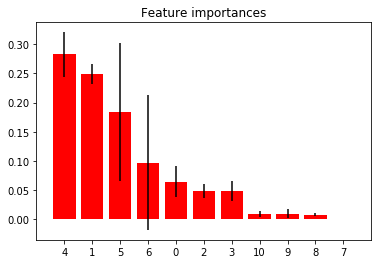

In [34]:
X = features
y = data_train["Survived"]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()